In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 준비와 확인

In [2]:
import pandas as pd
 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## 데이터 로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['조금', '같았다','것', '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    #결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    #단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    index_to_word = {index:word for word, index in word_to_index.items()}
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2 
    word_to_index["<UNUSED>"] = 3
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")


훈련 샘플 개수: 146182, 테스트 개수: 49157


In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터분석 및 가공

maxlen, padding 설정

In [5]:

# 두개의 기능 하나의 함수로 구현
def prepare_data_with_padding(X_train, X_test, word_to_index, padding='post', maxlen=None):
    """
    X_train과 X_test 데이터를 결합하여 문장 길이를 분석하고, 패딩을 적용하는 함수.

    Args:
    - X_train: 리스트, 훈련 데이터 (숫자 인덱스 시퀀스)
    - X_test: 리스트, 테스트 데이터 (숫자 인덱스 시퀀스)
    - word_to_index: 딕셔너리, 단어-인덱스 매핑
    - padding: 문자열, 패딩 위치 ('pre' 또는 'post')
    - maxlen: 정수, 시퀀스의 최대 길이 (None일 경우 자동 계산)

    Returns:
    - X_train_padded: 넘파이 배열, 패딩이 적용된 훈련 데이터
    - X_test_padded: 넘파이 배열, 패딩이 적용된 테스트 데이터
    - maxlen: 시퀀스의 최대 길이
    """
    # 1. X_train과 X_test를 결합하여 문장 길이 분석
    total_data_text = list(X_train) + list(X_test)
    num_tokens = [len(tokens) for tokens in total_data_text]
    num_tokens = np.array(num_tokens)

    # 문장 길이 통계 계산
    mean_length = np.mean(num_tokens)
    max_length = np.max(num_tokens)
    std_dev = np.std(num_tokens)

    print('문장길이 평균 : ', mean_length)
    print('문장길이 최대 : ', max_length)
    print('문장길이 표준편차 : ', std_dev)

    # 최대 문장 길이 설정 (평균 + 2*표준편차)
    if maxlen is None:
        maxlen = int(mean_length + 2 * std_dev)
    print('pad_sequences maxlen : ', maxlen)
    print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens) * 100:.2f}%가 maxlen 설정값 이내에 포함됩니다.')

    # 2. 패딩 적용
    X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X_train,
        value=word_to_index[""],
        padding=padding,
        maxlen=maxlen
    )

    X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X_test,
        value=word_to_index[""],
        padding=padding,
        maxlen=maxlen
    )

    # 결과 반환
    return X_train_padded, X_test_padded, maxlen

     

## 모델 구성 및 validation set 구성

In [6]:

# 하이퍼파라미터 설정
vocab_size = 10000  # 단어 사전 크기
word_vector_dim = 16  # 단어 임베딩 벡터 차원
batch_size = 64  # 학습 배치 크기
epochs = 15  # 학습 에포크 수

# 데이터 로드 및 전처리
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# prepare_data_with_padding에 word_to_index를 추가로 전달
X_train_padded, X_test_padded, maxlen = prepare_data_with_padding(X_train, X_test, word_to_index)

# 훈련 데이터와 검증 데이터를 나눔
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)


문장길이 평균 :  15.900066039039823
문장길이 최대 :  116
문장길이 표준편차 :  12.769373195633277
pad_sequences maxlen :  41
전체 문장의 93.15%가 maxlen 설정값 이내에 포함됩니다.


## 모델 훈련

모델 1 : LSTM(8)

In [7]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))  # LSTM 레이어의 출력 벡터 크기를 8로 설정
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력: 긍정/부정


model1.summary()
     

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 모델 컴파일
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history1 = model1.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# 모델 평가
test_loss, test_accuracy = model1.evaluate(X_test_padded, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

Epoch 1/15
1828/1828 [==============================] - 13s 5ms/step - loss: 0.4153 - accuracy: 0.7976 - val_loss: 0.3501 - val_accuracy: 0.8471
Epoch 2/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.3271 - accuracy: 0.8586 - val_loss: 0.3530 - val_accuracy: 0.8439
Epoch 3/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.3019 - accuracy: 0.8696 - val_loss: 0.3449 - val_accuracy: 0.8542
Epoch 4/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2785 - accuracy: 0.8805 - val_loss: 0.3421 - val_accuracy: 0.8519
Epoch 5/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2569 - accuracy: 0.8906 - val_loss: 0.3592 - val_accuracy: 0.8420
Epoch 6/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2390 - accuracy: 0.8981 - val_loss: 0.3746 - val_accuracy: 0.8540
Epoch 7/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2244 - accuracy: 0.9057 - val_loss: 0.3899 - val_accuracy

모델 2 : LSTM + Dropout (https://www.kaggle.com/code/furkannakdagg/sentiment-analysis-with-lstm)

In [9]:
model2 = tf.keras.Sequential()
# Add an embedding layer and a dropout
model2.add(tf.keras.layers.Embedding(input_dim=10000, output_dim=256))
model2.add(tf.keras.layers.Dropout(0.7))

#Add a LSTM layer with dropout
model2.add(tf.keras.layers.LSTM(256))
model2.add(tf.keras.layers.Dropout(0.7))  # dropout for LSTM Layer

# Add a Dense layer with dropout
model2.add(tf.keras.layers.Dense(128, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.7))

# Add the output layer
# In output layer number of nodes=number of classes => Since we are doing binary classification, there will be 1 node
# The output will be 0 or 1 with sigmoid
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 모델 학습
history2 = model2.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# 모델 평가
test_loss, test_accuracy = model2.evaluate(X_test_padded, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

Epoch 1/15
1828/1828 [==============================] - 16s 8ms/step - loss: 0.5087 - accuracy: 0.7301 - val_loss: 0.3579 - val_accuracy: 0.8428
Epoch 2/15
1828/1828 [==============================] - 14s 7ms/step - loss: 0.3501 - accuracy: 0.8531 - val_loss: 0.3304 - val_accuracy: 0.8565
Epoch 3/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.3111 - accuracy: 0.8713 - val_loss: 0.3150 - val_accuracy: 0.8640
Epoch 4/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2845 - accuracy: 0.8835 - val_loss: 0.3221 - val_accuracy: 0.8657
Epoch 5/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2654 - accuracy: 0.8916 - val_loss: 0.3434 - val_accuracy: 0.8658
Epoch 6/15
1828/1828 [==============================] - 14s 7ms/step - loss: 0.2503 - accuracy: 0.8985 - val_loss: 0.3316 - val_accuracy: 0.8644
Epoch 7/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2370 - accuracy: 0.9051 - val_loss: 0.3354 - val_ac

모델 3 : Transformer

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

# Transformer Block 정의
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-5)
        self.layernorm2 = LayerNormalization(epsilon=1e-5)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 모델 정의
def create_transformer_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(embedding_layer)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(rate)(x)
    x = Dense(256, activation="tanh")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 하이퍼파라미터
vocab_size = 10000   # 어휘 크기
maxlen = 41         # 시퀀스 길이
embed_dim = 128      # 임베딩 차원
num_heads = 4        # Multi-head Attention의 헤드 수
ff_dim = 256         # Position-wise Feedforward Network의 크기
dropout_rate = 0.1   # 드롭아웃 비율
epochs = 15          # 학습 에포크 수
batch_size = 64      # 배치 크기

# Transformer 모델 생성
model = create_transformer_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim, dropout_rate)

# 모델 컴파일
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# 데이터 준비 (X_train_final, X_val, y_train_final, y_val은 이미 전처리된 데이터)
# 패딩된 데이터 형태: (num_samples, maxlen)

# 모델 학습
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
transformer_block_5 (Transfo (None, 41, 128)           330240    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 128)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257 

## Loss, Accuracy 그래프 시각화

Model 1 : LSTM (8)


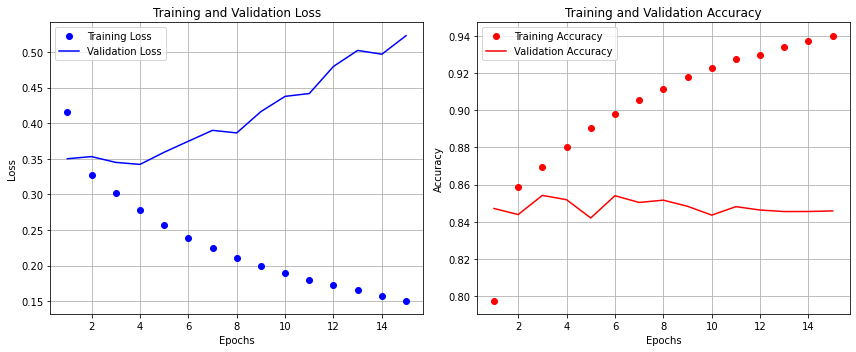

Model 2 : LSTM+Dropout


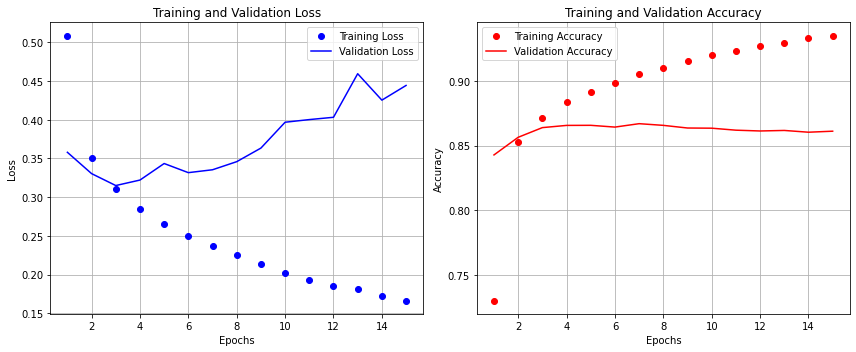

Model 3 : Transformer


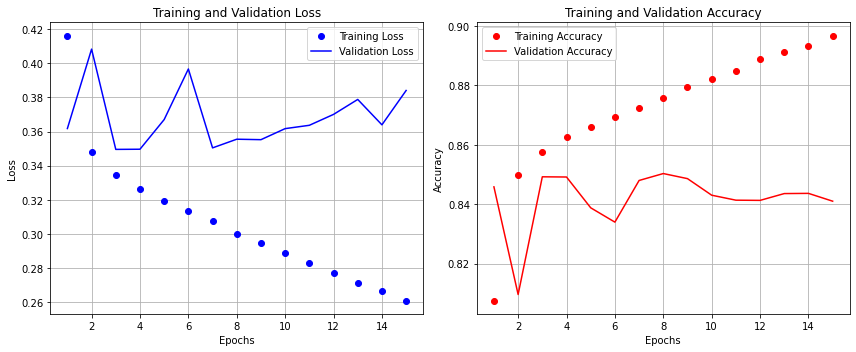

In [19]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    """
    훈련 및 검증 손실/정확도를 시각화하는 함수
    Args:
    - history: keras.callbacks.History 객체, 모델 학습 기록

    Returns:
    - None (그래프 출력)
    """
    # 손실과 정확도 데이터 가져오기
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # 에포크 설정
    epochs = range(1, len(loss) + 1)

    # 손실 그래프
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # 첫 번째 그래프
    plt.plot(epochs, loss, 'bo', label='Training Loss')  # 파란 점: 훈련 손실
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')  # 파란 실선: 검증 손실
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 정확도 그래프
    plt.subplot(1, 2, 2)  # 두 번째 그래프
    plt.plot(epochs, acc, 'ro', label='Training Accuracy')  # 빨간 점: 훈련 정확도
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')  # 빨간 실선: 검증 정확도
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # 그래프 표시
    plt.tight_layout()
    plt.show()
    
print("Model 1 : LSTM (8)")
plot_loss_and_accuracy(history1)
print("Model 2 : LSTM+Dropout")
plot_loss_and_accuracy(history2)
print("Model 3 : Transformer")
plot_loss_and_accuracy(history)

## 학습된 Embedding 레이어 분석

In [20]:
import pandas
import konlpy
import gensim
import os
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)


embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
word_vector_dim = weights.shape[1]

1.3.3
0.5.2
4.1.2
(10000, 256)


In [21]:
index_to_word = {index: word for word, index in word_to_index.items()}

# Word2Vec 형식으로 저장
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec1.txt'
with open(word2vec_file_path, 'w') as f:
    f.write(f'{vocab_size-4} {word_vector_dim}\n')  # 벡터 차원 동적으로 설정

    for i in range(4, vocab_size):  # 특수 토큰 제외
        f.write(f'{index_to_word[i]} {" ".join(map(str, weights[i]))}\n')

print(f"Word2Vec 파일 저장 완료: {word2vec_file_path}")

# Word2Vec 파일 로드 및 테스트
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['노래']
print(vector)

Word2Vec 파일 저장 완료: /aiffel/aiffel/sentiment_classification/data/word2vec1.txt
[ 0.18270741 -0.05042277 -0.16378696 -0.05027144  0.1016456  -0.26484928
  0.04028901 -0.00670538 -0.25154403 -0.14458403  0.06098228 -0.1995467
 -0.10068008  0.1588901   0.14837193 -0.14428744  0.00130513  0.18851829
 -0.102874   -0.14093152  0.08610336  0.0996649   0.04776252  0.00074158
 -0.01761888  0.13764107 -0.203997    0.14690118  0.05341906 -0.22238626
 -0.03104116 -0.04680994 -0.06479747 -0.10990979  0.09830487 -0.05385317
  0.14719574  0.25383252 -0.11908299 -0.3223331   0.05185928 -0.03476659
  0.34948313  0.14445221  0.08702252 -0.04209452  0.11634126 -0.04174456
  0.06099734 -0.19888985  0.0542697  -0.2990698   0.00730269  0.00718809
  0.12724043 -0.23777618 -0.10627098  0.05487972 -0.09300759  0.01656817
 -0.18497846  0.21065074  0.14279719  0.04463235  0.07143486  0.12616481
  0.04554704 -0.10840514 -0.08496054  0.14359482  0.04684767 -0.20359573
 -0.30930758 -0.41771212 -0.1242585   0.0470172

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]
        
from tensorflow.keras.initializers import Constant


# 모델 구성
model2 = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
# Add an embedding layer and a dropout
model2.add(tf.keras.layers.Embedding(input_dim=10000, output_dim=256))
model2.add(tf.keras.layers.Dropout(0.7))

#Add a LSTM layer with dropout
model2.add(tf.keras.layers.LSTM(256))
model2.add(tf.keras.layers.Dropout(0.7))  # dropout for LSTM Layer

# Add a Dense layer with dropout
model2.add(tf.keras.layers.Dense(128, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.7))

# Add the output layer
# In output layer number of nodes=number of classes => Since we are doing binary classification, there will be 1 node
# The output will be 0 or 1 with sigmoid
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 모델 학습
history21 = model2.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# 모델 평가
test_loss, test_accuracy = model2.evaluate(X_test_padded, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

Epoch 1/15
1828/1828 [==============================] - 16s 8ms/step - loss: 0.4624 - accuracy: 0.7683 - val_loss: 0.3463 - val_accuracy: 0.8473
Epoch 2/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.3429 - accuracy: 0.8594 - val_loss: 0.3530 - val_accuracy: 0.8456
Epoch 3/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.3080 - accuracy: 0.8741 - val_loss: 0.3207 - val_accuracy: 0.8593
Epoch 4/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2843 - accuracy: 0.8852 - val_loss: 0.3185 - val_accuracy: 0.8652
Epoch 5/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2674 - accuracy: 0.8923 - val_loss: 0.3301 - val_accuracy: 0.8679
Epoch 6/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2508 - accuracy: 0.8999 - val_loss: 0.3405 - val_accuracy: 0.8686
Epoch 7/15
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2385 - accuracy: 0.9045 - val_loss: 0.3403 - val_ac

자체학습 모델과 사전학습 모델의 비교

Model 2 : LSTM+Dropout


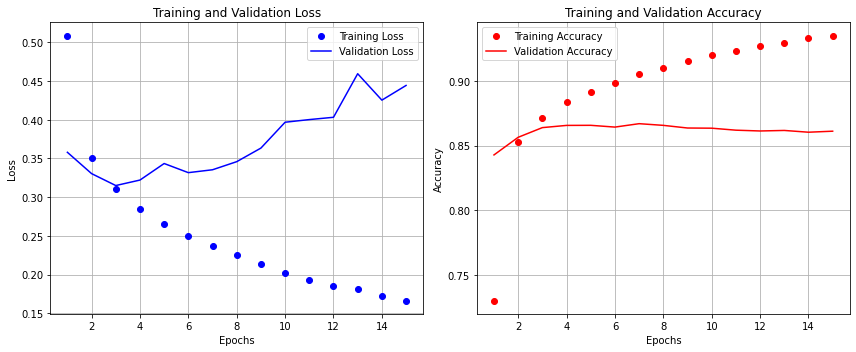

Model 2 : LSTM+Dropout+Word2Vec


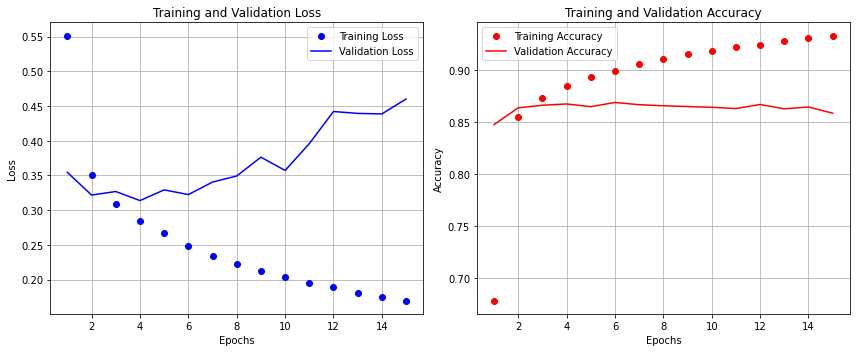

In [33]:
print("Model 2 : LSTM+Dropout")
plot_loss_and_accuracy(history2)
print("Model 2 : LSTM+Dropout+Word2Vec")
plot_loss_and_accuracy(history21)

성능이 향상되지는 않음. 거의 비슷합.

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
import numpy as np
import tensorflow as tf
from gensim.models.keyedvectors import KeyedVectors

# 사전 학습된 한국어 Word2Vec 파일 로드
word2vec_path =  os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Word2Vec 모델의 벡터 차원 확인
word_vector_dim = word_vectors.vector_size
print(f"Word2Vec 벡터 차원: {word_vector_dim}")

# Vocabulary 및 임베딩 매트릭스 생성
vocab_size = 10000  # 어휘 사전의 크기 (임의로 10,000개로 설정)
embedding_matrix = np.zeros((vocab_size, word_vector_dim))  # 0으로 초기화된 임베딩 매트릭스

# Word2Vec의 단어와 인덱스를 매핑하는 사전 생성
word_to_index = {word: i for i, word in enumerate(word_vectors.index_to_key[:vocab_size])}
index_to_word = {i: word for word, i in word_to_index.items()}

# Word2Vec 임베딩 값을 매트릭스에 복사
for word, i in word_to_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

print(f"임베딩 매트릭스 생성 완료. Shape: {embedding_matrix.shape}")

# TensorFlow 임베딩 레이어에 사전 학습된 벡터 적용
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=word_vector_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=maxlen,
    trainable=False)  # 사전 학습된 벡터를 고정

model2 = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
# Add an embedding layer and a dropout
model2.add(tf.keras.layers.Embedding(input_dim=10000, output_dim=256))
model2.add(tf.keras.layers.Dropout(0.7))

#Add a LSTM layer with dropout
model2.add(tf.keras.layers.LSTM(256))
model2.add(tf.keras.layers.Dropout(0.7))  # dropout for LSTM Layer

# Add a Dense layer with dropout
model2.add(tf.keras.layers.Dense(128, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.7))

# Add the output layer
# In output layer number of nodes=number of classes => Since we are doing binary classification, there will be 1 node
# The output will be 0 or 1 with sigmoid
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 모델 학습
history2 = model2.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# 모델 평가
test_loss, test_accuracy = model2.evaluate(X_test_padded, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

In [ ]:
import numpy as np
import tensorflow as tf
from gensim.models.keyedvectors import KeyedVectors

# 사전 학습된 한국어 Word2Vec 파일 로드
word2vec_path =  os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Word2Vec 모델의 벡터 차원 확인
word_vector_dim = word_vectors.vector_size
print(f"Word2Vec 벡터 차원: {word_vector_dim}")

# Vocabulary 및 임베딩 매트릭스 생성
vocab_size = 10000  # 어휘 사전의 크기 (임의로 10,000개로 설정)
embedding_matrix = np.zeros((vocab_size, word_vector_dim))  # 0으로 초기화된 임베딩 매트릭스

# Word2Vec의 단어와 인덱스를 매핑하는 사전 생성
word_to_index = {word: i for i, word in enumerate(word_vectors.index_to_key[:vocab_size])}
index_to_word = {i: word for word, i in word_to_index.items()}

# Word2Vec 임베딩 값을 매트릭스에 복사
for word, i in word_to_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

print(f"임베딩 매트릭스 생성 완료. Shape: {embedding_matrix.shape}")

# TensorFlow 임베딩 레이어에 사전 학습된 벡터 적용
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=word_vector_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=maxlen,
    trainable=False  # 사전 학습된 벡터를 고정
)

# 모델 구성
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 모델 컴파일
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 모델 학습
history = model.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")


## 회고


cloud jupyter를 사용중인데 이정도로 코드가 길어지면 자꾸 커널이 죽어서 더이상의 실습이 진행되지 않는다. 다시 진행해야 할 것 같다.
스킬이 아직 부족해 여러가지 찾아 보다 결국 용석님 코드를 가장 참고해서 작성했다. 
사전학습 없이 87% 이상의 성능을 내는 모델을 짜 보려고 캐글에서 찾은Transformer BERT을 적용해보았으나 3시간 이상 걸리고 3에포크에도 개선이 되는 모습이 보이지 않았다.
BERT가 아닌 트랜스포머 모델을 케라스에서 찾아서 넣어 만들었다. 
열심히 해보려고 밤을 샜는데 생각한 것 만큼 결과가 좋진 않은것 같다
오늘도 화이팅!
